# Libraries

In [8]:
!pip install matplotlib numpy GDAL rioxarray scipy tqdm yellowbrick scikit-learn tensorflow

In [9]:
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from osgeo import gdal
from osgeo import osr
# import pandas as pd
# import rasterio as rio
import rioxarray as rxr
from scipy.ndimage.filters import generic_filter
from scipy.stats import mode
from scipy.ndimage import generic_filter
# import seaborn as sns
# from time import time
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
from yellowbrick.cluster import KElbowVisualizer

from sklearn import cluster
# from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import StandardScaler

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1

/tmp/ipython-input-9-3663801695.py:13: DeprecationWarning: Please import `generic_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import generic_filter


# Loading the datasets

In [11]:
!gdalinfo /content/AST_L1T_00304152025035239_20250416183712_1431265_V.tif

/bin/bash: line 1: gdalinfo: command not found


In [12]:
!apt-get install -y gdal-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 2s (3,100 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 126308 files and direc

In [13]:
!gdalinfo /content/AST_L1T_00304152025035239_20250416183712_1431265_V.tif

Driver: GTiff/GeoTIFF
Files: /content/AST_L1T_00304152025035239_20250416183712_1431265_V.tif
Size is 5575, 4921
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 45N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 45N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",87,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre

In [14]:
# load the data
data_raster = rxr.open_rasterio('/content/AST_L1T_00304152025035239_20250416183712_1431265_V.tif').squeeze()

min_x = float(data_raster.coords['x'].min())
max_x = float(data_raster.coords['x'].max())
min_y = float(data_raster.coords['y'].min())
max_y = float(data_raster.coords['y'].max())

extent = [min_x, max_x, min_y, max_y]

# read the data
data_array = np.array(data_raster)

# reshape the input data from brc to rcb
data_xyb = np.empty((data_raster.shape[1], data_raster.shape[2], data_raster.shape[0]))
# loop through the bands to fill the empty array
for band in range(data_xyb.shape[2]):
    data_xyb[:, :, band] = data_array[band, :, :]

data_reshaped = data_xyb.reshape(data_xyb.shape[0]*data_xyb.shape[1], -1)
# scale the data
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)

# Principal components analysis

In [15]:
# pca
pca = PCA()
components = pca.fit_transform(data_reshaped)
# eigenvectors = pca.components_
# eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.9:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:, :i]
print('Number of components:', selected_components.shape[1])

Number of components: 1


# Elbow method

In [17]:
import os
os.makedirs("Figures", exist_ok=True)

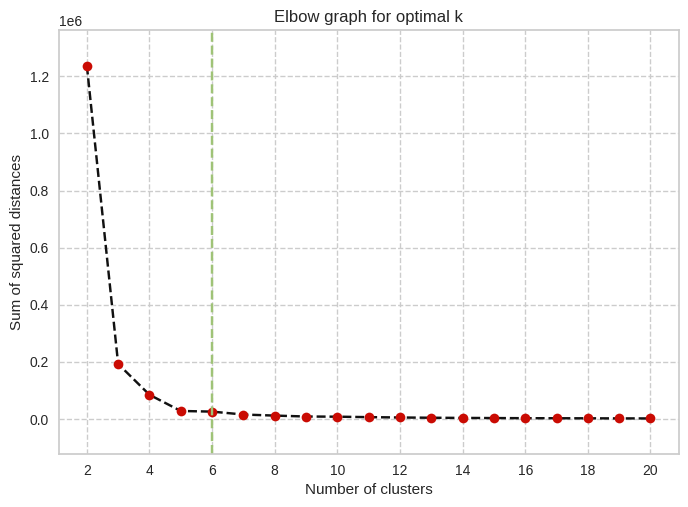

In [18]:
# elbow method
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=6, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.savefig('./Figures/pca_kmeans_aster_elbow.png', dpi=300)
plt.show()

# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(selected_components)
# # finalize and render figure
# visualizer.show()

# k-means

In [ ]:
# k-means
n_clusters = 6

# create an object of the classifier
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# train
pred = clusterer.fit_predict(selected_components) # Train
# get cluster labels
labels = clusterer.labels_

# Calinski-Harabasz score
ch_score = calinski_harabasz_score(selected_components, labels),
# Davies-Bouldin score
# The minimum score is zero, and the lower values the better clustering performance
db_score = davies_bouldin_score(selected_components, labels)
print('Calinski-Harabasz score:', round(ch_score[0], 4))
print('Davies-Bouldin score:', round(db_score, 4))

# reshape the labels to a 3D array (single band)
labels = labels.reshape(data_array[0, :, :].shape)

def filter_function(invalues):
    invalues_mode = mode(invalues, axis=None, nan_policy='omit')
    return invalues_mode[0]

labels_major = generic_filter(labels, function=filter_function, size=7)

def plot_map(array, extent, n_clusters):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cmap = cm.get_cmap('rainbow', n_clusters)
    plt.imshow(array, cmap=cmap, extent=extent)
    cbar = plt.colorbar(label='Cluster Number')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    plt.grid(False)

plot_map(labels_major, extent, n_clusters)

Calinski-Harabasz score: 2801853193.9524
Davies-Bouldin score: 0.3887


Exception ignored in: <function _xla_gc_callback at 0x7b2ae45bf420>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7b2ae45bf420>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


In [ ]:
# export the map to a GeoTIFF file
dist_x = 15
dist_y = 15
geotransform = (min_x, dist_x, 0, max_y, 0, -dist_y)
map_file = './GIS/pca_kmeans_aster.tiff'

driver = gdal.GetDriverByName('GTiff')
nx = labels_major.shape[1]
ny = labels_major.shape[0]
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32754)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(labels_major)
dataset.FlushCache()
dataset = None

# Canonical autoencoder

Epoch 1/10
47667/47667 [==============================] - 40s 819us/step - loss: 0.0012 - accuracy: 0.3945
Epoch 2/10
47667/47667 [==============================] - 39s 823us/step - loss: 8.6386e-04 - accuracy: 0.4024
Epoch 3/10
47667/47667 [==============================] - 40s 834us/step - loss: 8.5629e-04 - accuracy: 0.4055
Epoch 4/10
47667/47667 [==============================] - 39s 826us/step - loss: 8.5244e-04 - accuracy: 0.4076
Epoch 5/10
47667/47667 [==============================] - 40s 838us/step - loss: 8.4969e-04 - accuracy: 0.4085
Epoch 6/10
47667/47667 [==============================] - 41s 852us/step - loss: 8.4752e-04 - accuracy: 0.4092
Epoch 7/10
47667/47667 [==============================] - 41s 866us/step - loss: 8.4573e-04 - accuracy: 0.4094
Epoch 8/10
47667/47667 [==============================] - 41s 855us/step - loss: 8.4443e-04 - accuracy: 0.4093
Epoch 9/10
47667/47667 [==============================] - 41s 857us/step - loss: 8.4338e-04 - accuracy: 0.4091
Epoch

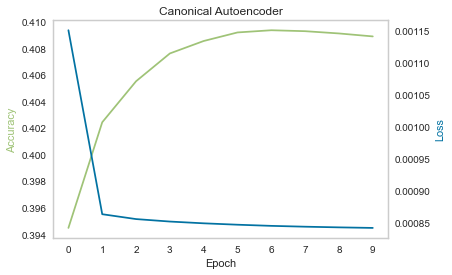

In [ ]:
# autoencoder
learning_rate = 1e-4
epochs = 10

# num of predictor variables
input_dim = data_reshaped.shape[1]
input_layer = Input(shape=(input_dim, ), name='input')

# input layer
encoder_1 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
# first encoder
encoder_2 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
# code layer
encoder_3 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
# first decoder
decoder_1 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
# second decoder
decoder_2 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
# output layer
decoder_3 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_2)

autoencoder = Model(inputs=input_layer, outputs=decoder_3)
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
history = autoencoder.fit(data_reshaped, data_reshaped, epochs=epochs, batch_size=64)

encoder = Model(inputs=input_layer, outputs=encoder_3)
data_ae = encoder.predict(data_reshaped)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], 'g-')
ax2.plot(history.history['loss'], 'b-')
ax1.set_title('Canonical Autoencoder')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax1.set_xlabel('Epoch')
ax1.set_xticks(list(range(epochs)))
ax1.grid(False)
ax2.grid(False)
plt.show()

# Elbow method

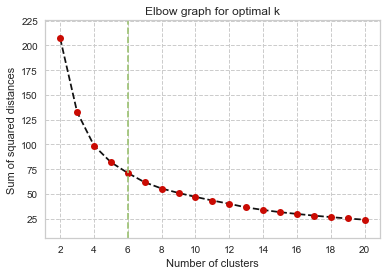

In [ ]:
# elbow method
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(data_ae)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=6, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.savefig('./Figures/ae_kmeans_aster_elbow.png', dpi=300)
plt.show()

# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(data_ae)
# # finalize and render figure
# visualizer.show()

# k-means

Calinski-Harabasz score: 3127689.6241
Davies-Bouldin score: 0.8973


C:\Users\efar0517\AppData\Local\Temp\ipykernel_17028\392812028.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  invalues_mode = mode(invalues, axis=None, nan_policy='omit')


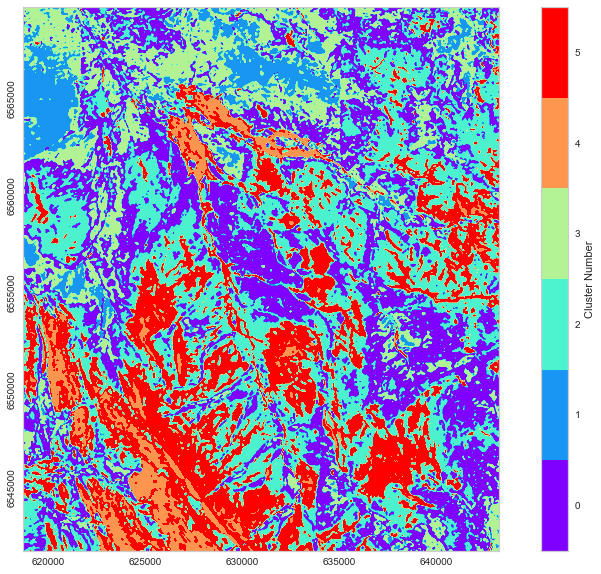

In [ ]:
# k-means
n_clusters = 6

# create an object of the classifier
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# train
pred = clusterer.fit_predict(data_ae)
# get cluster labels
labels = clusterer.labels_

# Calinski-Harabasz score
ch_score = calinski_harabasz_score(data_ae, labels)
# Davies-Bouldin score
# The minimum score is zero, and the lower values the better clustering performance
db_score = davies_bouldin_score(data_ae, labels)
print('Calinski-Harabasz score:', round(ch_score, 4))
print('Davies-Bouldin score:', round(db_score, 4))

# reshape the labels to a 3D array (single band)
labels = labels.reshape(data_array[0, :, :].shape)
labels_major = generic_filter(labels, function=filter_function, size=7)
plot_map(labels_major, extent, n_clusters)

In [ ]:
# export the map to a GeoTIFF file
dist_x = 15
dist_y = 15
geotransform = (min_x, dist_x, 0, max_y, 0, -dist_y)
map_file = './GIS/ae_kmeans_aster.tiff'

driver = gdal.GetDriverByName('GTiff')
nx = labels_major.shape[1]
ny = labels_major.shape[0]
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32754)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(labels_major)
dataset.FlushCache()
dataset = None

# Stacked autoencoder

In [ ]:
# stacked autoencoder
def model_1(input_layer, input_dim):
    # input layer
    encoder_1 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
    # first encoder
    encoder_2 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
    # code layer
    encoder_3 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
    # first decoder
    decoder_1 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
    # second decoder
    decoder_2 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
    # output layer
    decoder_3 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_2)

    return Model(inputs=input_layer, outputs=decoder_3)

# num of predictor variables
input_dim_1 = data_reshaped.shape[1]
input_layer_1 = Input(shape=(input_dim_1, ), name='input')

autoencoder_1 = model_1(input_layer_1, input_dim_1)
autoencoder_1.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
stack_1 = autoencoder_1.fit(data_reshaped, data_reshaped, epochs=10, batch_size=64)

autoencoder_2_input = autoencoder_1.predict(data_reshaped)
autoencoder_2_input = np.concatenate((autoencoder_2_input , data_reshaped), axis=1)

def model_2(input_layer, input_dim):
    # input layer
    encoder_1 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
    # first encoder
    encoder_2 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
    # code layer
    encoder_3 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
    # first decoder
    decoder_1 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
    # second decoder
    decoder_2 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
    # output layer
    decoder_3 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_2)

    return Model(inputs=input_layer, outputs=decoder_3), Model(inputs=input_layer, outputs=encoder_2)

input_dim_2 = autoencoder_2_input.shape[1]
input_layer_2 = Input(shape=(input_dim_2, ), name='input')

autoencoder_2, encoder_2 = model_2(input_layer_2, input_dim_2)
autoencoder_2.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
stack_2 = autoencoder_2.fit(autoencoder_2_input, autoencoder_2_input, epochs=5, batch_size=32)

autoencoder_3_input = encoder_2.predict(autoencoder_2_input)
autoencoder_3_input = np.concatenate((autoencoder_3_input, autoencoder_2_input), axis=1)

def model_3(input_layer, input_dim):
    # input layer
    encoder_1 = Dense(15, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
    # first encoder
    encoder_2 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
    # second encoder
    encoder_3 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
    # third encoder
    encoder_4 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
    # first decoder
    decoder_1 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_4)
    # second decoder
    decoder_2 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
    # third decoder
    decoder_3 = Dense(15, activation='selu', activity_regularizer=l1(learning_rate))(decoder_2)
    # output layer
    decoder_4 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_3)

    return Model(inputs=input_layer, outputs=decoder_4), Model(inputs=input_layer, outputs=encoder_4)

input_dim_3 = autoencoder_3_input.shape[1]
input_layer_3 = Input(shape=(input_dim_3, ), name='input')

autoencoder_3, encoder_3 = model_3(input_layer_3, input_dim_3)
autoencoder_3.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
stack_3 = autoencoder_3.fit(autoencoder_3_input, autoencoder_3_input, epochs=5, batch_size=16)

data_sae = encoder_3.predict(autoencoder_3_input)

Epoch 1/10
47667/47667 [==============================] - 41s 838us/step - loss: 0.0011 - accuracy: 0.3976
Epoch 2/10
47667/47667 [==============================] - 40s 842us/step - loss: 8.7102e-04 - accuracy: 0.4048
Epoch 3/10
47667/47667 [==============================] - 40s 849us/step - loss: 8.6157e-04 - accuracy: 0.4055
Epoch 4/10
47667/47667 [==============================] - 41s 851us/step - loss: 8.5535e-04 - accuracy: 0.4100
Epoch 5/10
47667/47667 [==============================] - 40s 841us/step - loss: 8.5096e-04 - accuracy: 0.4101
Epoch 6/10
47667/47667 [==============================] - 41s 856us/step - loss: 8.4801e-04 - accuracy: 0.4097
Epoch 7/10
47667/47667 [==============================] - 40s 846us/step - loss: 8.4529e-04 - accuracy: 0.4103
Epoch 8/10
47667/47667 [==============================] - 42s 876us/step - loss: 8.4347e-04 - accuracy: 0.4103
Epoch 9/10
47667/47667 [==============================] - 42s 889us/step - loss: 8.4215e-04 - accuracy: 0.4101
Epoch

# Elbow method

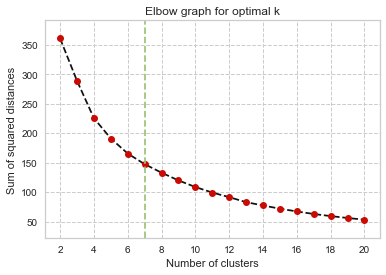

In [ ]:
# elbow method
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(data_sae)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=7, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.savefig('./Figures/sae_kmeans_aster_elbow.png', dpi=300)
plt.show()

# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(data_sae)
# # finalize and render figure
# visualizer.show()

# k-means

Calinski-Harabasz score: 1645732.6604
Davies-Bouldin score: 0.9066


C:\Users\efar0517\AppData\Local\Temp\ipykernel_17028\392812028.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  invalues_mode = mode(invalues, axis=None, nan_policy='omit')


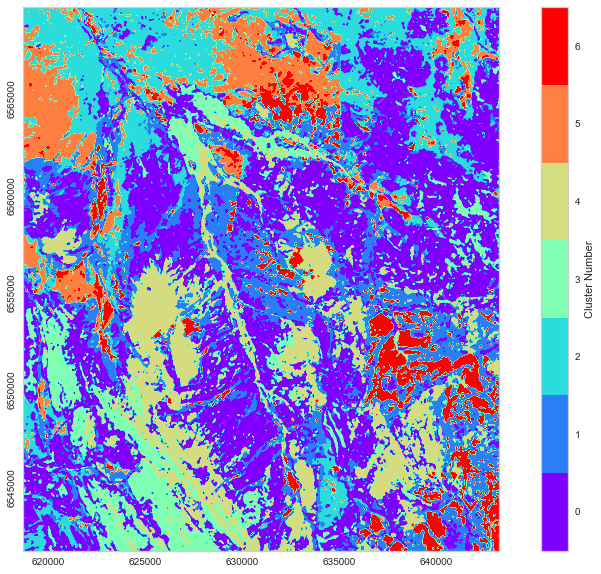

In [ ]:
# k-means
n_clusters = 7

# create an object of the classifier
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# train
pred = clusterer.fit_predict(data_sae)
# get cluster labels
labels = clusterer.labels_

# Calinski-Harabasz score
ch_score = calinski_harabasz_score(data_sae, labels)
# Davies-Bouldin score
# The minimum score is zero, and the lower values the better clustering performance
db_score = davies_bouldin_score(data_sae, labels)
print('Calinski-Harabasz score:', round(ch_score, 4))
print('Davies-Bouldin score:', round(db_score, 4))

# reshape the labels to a 3D array (single band)
labels = labels.reshape(data_array[0, :, :].shape)
labels_major = generic_filter(labels, function=filter_function, size=7)
plot_map(labels_major, extent, n_clusters)

In [ ]:
# export the map to a GeoTIFF file
dist_x = 15
dist_y = 15
geotransform = (min_x, dist_x, 0, max_y, 0, -dist_y)
map_file = './GIS/sae_kmeans_aster.tiff'

driver = gdal.GetDriverByName('GTiff')
nx = labels_major.shape[1]
ny = labels_major.shape[0]
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32754)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(labels_major)
dataset.FlushCache()
dataset = None